
# Pump sensors predictive maintenance

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('../input/sensor.csv')

In [ ]:
df.shape
df.columns
100*df.isna().sum()/len(df)

Unnamed: 0          0.000000
timestamp           0.000000
sensor_00           4.633261
sensor_01           0.167484
sensor_02           0.008624
sensor_03           0.008624
sensor_04           0.008624
sensor_05           0.008624
sensor_06           2.177741
sensor_07           2.474129
sensor_08           2.317992
sensor_09           2.085603
sensor_10           0.008624
sensor_11           0.008624
sensor_12           0.008624
sensor_13           0.008624
sensor_14           0.009532
sensor_15         100.000000
sensor_16           0.014070
sensor_17           0.020879
sensor_18           0.020879
sensor_19           0.007262
sensor_20           0.007262
sensor_21           0.007262
sensor_22           0.018609
sensor_23           0.007262
sensor_24           0.007262
sensor_25           0.016340
sensor_26           0.009078
sensor_27           0.007262
sensor_28           0.007262
sensor_29           0.032680
sensor_30           0.118464
sensor_31           0.007262
sensor_32     

In [ ]:
#Remove sensor_15 and sensor_50, too many missing values

In [ ]:
df = df.drop(['sensor_15','sensor_50','Unnamed: 0'],axis=1)

In [ ]:
100*df['machine_status'].value_counts()/len(df)

NORMAL        93.425926
RECOVERING     6.570897
BROKEN         0.003177
Name: machine_status, dtype: float64

In [ ]:
columns = [col for col in df.columns if not col.find('sensor')]
for col in columns:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
df.isna().sum()

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0


# Correlations

In [ ]:
corr = df.corr()

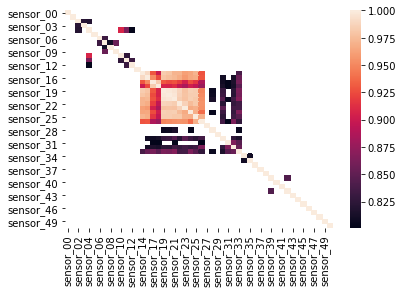

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

corr80 = corr[abs(corr)> 0.8]
sns.heatmap(corr80)

We can notice two groups of sensors highly correlated (sensor 15-25) and (sensors 14-29)

In [ ]:
from sklearn.decomposition import PCA

data = df[[sensor for sensor in df.columns.tolist() if not sensor.find('sensor')]]

pca = PCA(n_components=2)
data_reduce = pca.fit_transform(data)

73% of the variance is explained by the first component

In [ ]:
print(pca.explained_variance_ratio_)

[0.73635084 0.08280067]


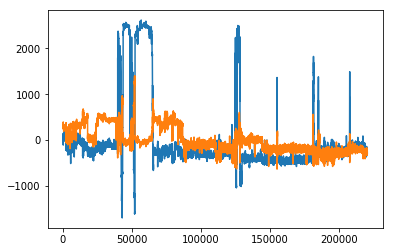

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data_reduce)

In [ ]:
data_reduce

array([[  69.52313434,  265.70457125],
       [  69.52313434,  265.70457125],
       [  27.84156936,  283.46219674],
       ...,
       [-300.20765415, -256.93272652],
       [-285.14138985, -263.09947147],
       [-298.18252618, -264.54595337]])

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
model = VAR(pd.DataFrame(data_reduce))

In [ ]:
results = model.fit(2)

In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Mar, 2020
Time:                     16:57:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.9097
Nobs:                     220318.    HQIC:                   11.9094
Log likelihood:      -1.93714e+06    FPE:                    148635.
AIC:                      11.9092    Det(Omega_mle):         148628.
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.001830         0.058225           -0.031           0.975
L1.0          0.803889         0.002608          308.226           0.000
L1.1          0.065414         0.004099           15.960           0.000
L2.0          0.195670 

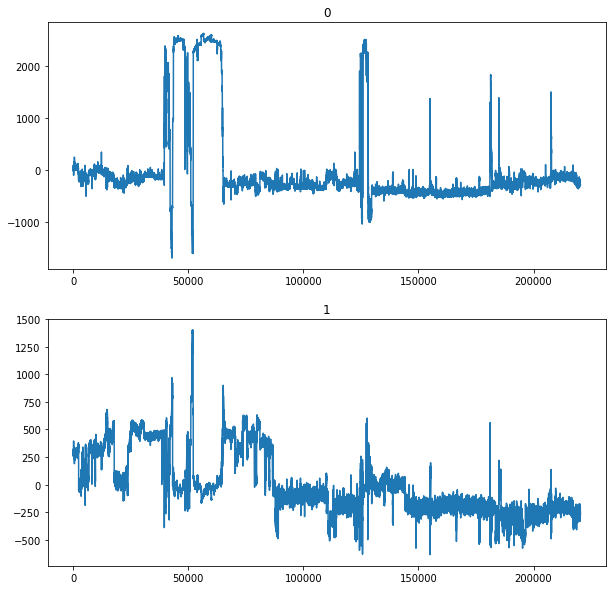

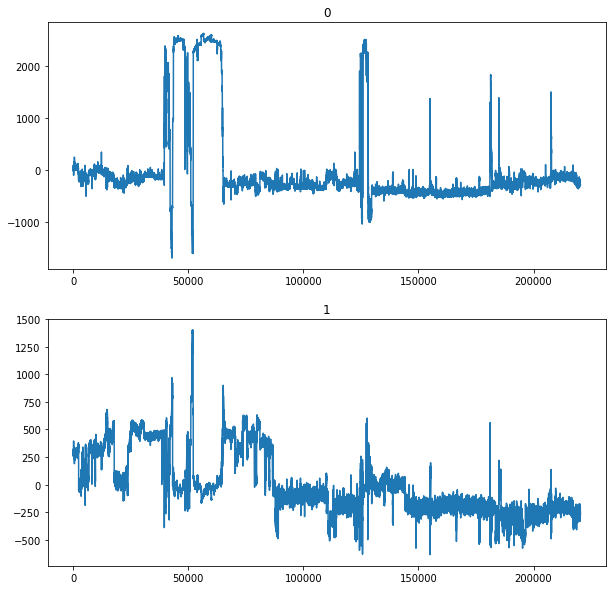

In [ ]:
results.plot()

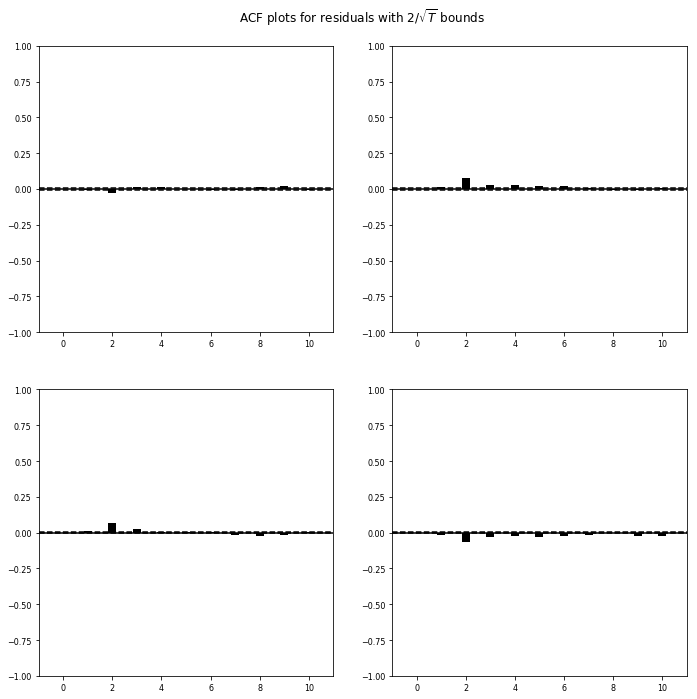

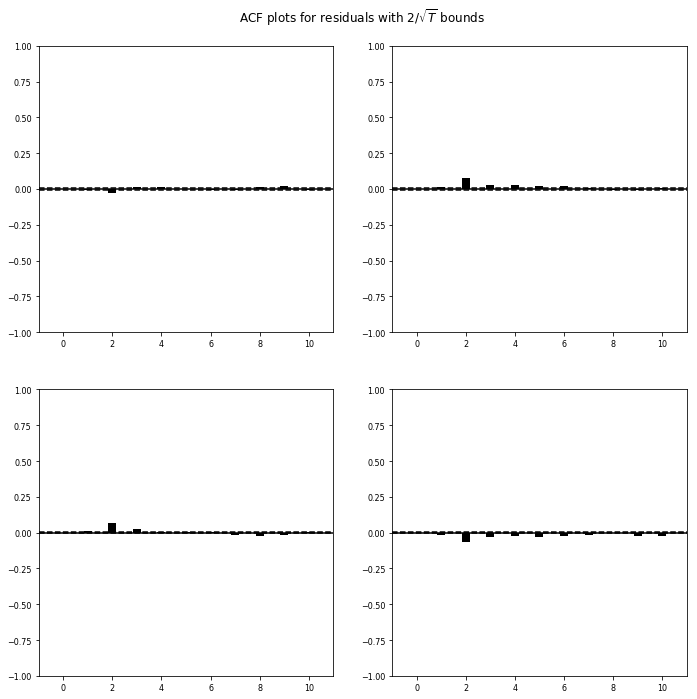

In [ ]:
results.plot_acorr()

2


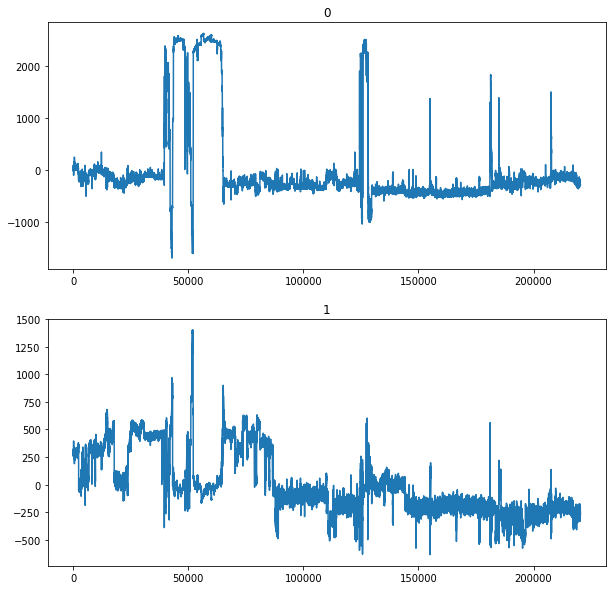

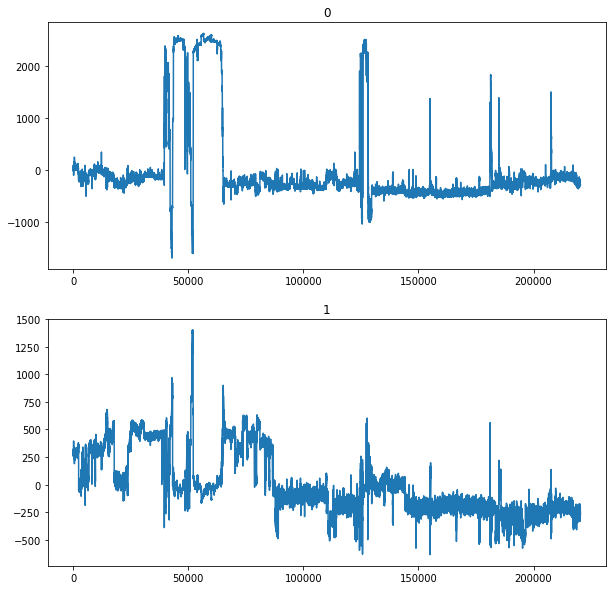

In [ ]:
lag_order = results.k_ar
print(lag_order)
results.plot()

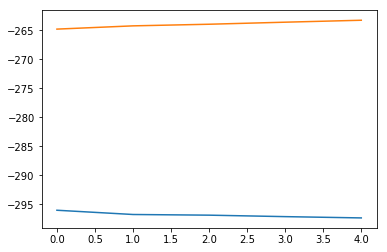

In [ ]:
plt.plot(results.forecast(pd.DataFrame(data_reduce).values[-lag_order:], 5))

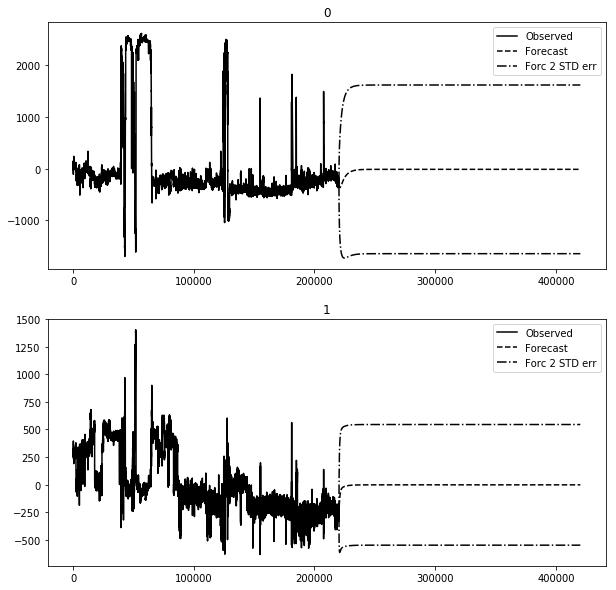

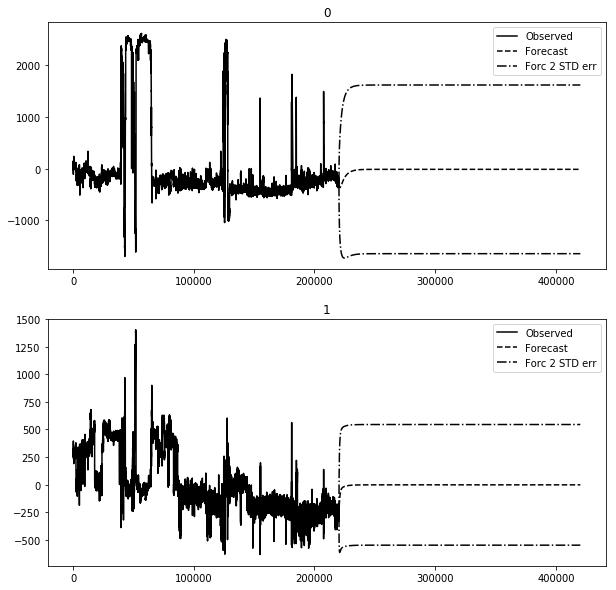

In [ ]:
results.plot_forecast(200000)

ARIMA results are not convicing, let's try another approach.

# LSTM models

In [ ]:
!pip install pyjanitor

     |████████████████████████████████| 63 kB 949 kB/s 


Transform timestamp to datetime type

In [ ]:
import datetime

format_str = '%Y-%m-%d %H:%M:%S'  # The format

df['timestamp'] = pd.DataFrame([datetime.datetime.strptime(date, format_str) for date in df['timestamp']])
#y = df.groupby(df.timestamp.dt.year).count()['Date'].values
#x = df.groupby(df.timestamp.dt.year).count()['Date'].index

For the LSTM approach, we have to calculate remaining useful life i.e time before broken for earch rows

In [ ]:
import janitor

def calculate_rul(df):
    
    df_broken = df[df['machine_status'] == 'BROKEN']
    L=[]
    d = df['timestamp'].iloc[0]
    for date_broken in df_broken['timestamp']:
        
        df_filtered = df.filter_date('timestamp',d, date_broken)
        df_filtered['rul'] = date_broken - df_filtered['timestamp']
        
        L.append(df_filtered)
        d = date_broken
    
    #L.append(df.filter_date('timestamp',df_broken['timestamp'].iloc[-1], df['timestamp'].iloc[-1]))
    result = pd.concat(L)
    

    return result.loc[~result.index.duplicated(keep='first')] #remove duplicates indices

df_rul = calculate_rul(df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Let's now define a label to define if we are 4 days before a failure. I choose 4 days because of the regularity of the failure. This is the target label we want to predict.

In [ ]:
df_rul['rul']

delta_t = np.timedelta64(4, 'D')
delta_t_2 = np.timedelta64(2, 'D')

In [ ]:
# Label1 indicates a failure will occur within the next 30 cycles.
# 1 indicates failure, 0 indicates healthy 
df_rul['label1'] = np.where(df_rul['rul'] <= delta_t, 1, 0 )

Scale the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cols_normalize = df_rul.columns.difference(['id','timestamp','rul','label1','label2','machine_status'])

scaler = MinMaxScaler()

df_rul[cols_normalize] = scaler.fit_transform(df_rul[cols_normalize])

In [ ]:
df_rul["rul"] = df_rul["rul"].apply(lambda x: x.total_seconds()/3600) #converting to hours

In [ ]:
#separate in train and test dataset
df_rul[df_rul['machine_status'] =="BROKEN"]

df_rul['time_norm']= df_rul['timestamp'].values.tolist()
df_rul["time_norm"] = (df_rul["time_norm"]-df_rul["time_norm"].min())/(df_rul["time_norm"].max()-df_rul["time_norm"].min())

train_df = df_rul.iloc[:77790,:].drop(['machine_status',"timestamp"],axis=1)
train_df["time_norm"] = (train_df["time_norm"]-train_df["time_norm"].min())/(train_df["time_norm"].max()-train_df["time_norm"].min())


test_df = df_rul.iloc[77791:,:].drop(['machine_status',"timestamp"],axis=1)
test_df["time_norm"] = (test_df["time_norm"]-test_df["time_norm"].min())/(test_df["time_norm"].max()-test_df["time_norm"].min())

train_df['rul'] = train_df['rul'].values.tolist()

In [ ]:
test_df['rul'].describe()

count    88650.000000
mean       313.676782
std        231.096187
min          0.000000
25%        123.116667
50%        260.275000
75%        468.112500
max        837.483333
Name: rul, dtype: float64

Let's now shape the data for a LSTM network. I inspire from this notebook that explain how to use LSTM for predictive maintenance.
https://github.com/Azure-Samples/MachineLearningSamples-DeepLearningforPredictiveMaintenance/blob/master/Code/2_model_building_and_evaluation.ipynb

In [ ]:
features_col_name=[column for column in df.columns if not column.find('sensor')]
target_col_name='label1'

features_col_name

['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_05',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26',
 'sensor_27',
 'sensor_28',
 'sensor_29',
 'sensor_30',
 'sensor_31',
 'sensor_32',
 'sensor_33',
 'sensor_34',
 'sensor_35',
 'sensor_36',
 'sensor_37',
 'sensor_38',
 'sensor_39',
 'sensor_40',
 'sensor_41',
 'sensor_42',
 'sensor_43',
 'sensor_44',
 'sensor_45',
 'sensor_46',
 'sensor_47',
 'sensor_48',
 'sensor_49',
 'sensor_51']

In [ ]:
# window size
seq_length=100
seq_cols=features_col_name

In [ ]:
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [ ]:
# generate X_train for LSTM 3D dimension array
seq_gen = [list(gen_sequence(train_df, seq_length, seq_cols))]

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(77690, 100, 50)


In [ ]:
label_gen = [gen_labels(train_df, seq_length, ['label1'])]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(77690, 1)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense, Dropout, LSTM, Activation

Using TensorFlow backend.


In [ ]:
from sklearn.metrics import fbeta_score
from keras import backend as K


def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 10

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

Let's define the network:

This is a network of only 2 layers, with dropout. The first LSTM layer with 100 units, one for each input sequence, followed by another LSTM layer with 50 units. We will also apply dropout each LSTM layer to control overfitting. The final dense output layer employs a sigmoid activation corresponding to the binary classification requirement.

We choose the Fbeta metrics for this kind of problems.

In [ ]:
from sklearn.metrics import fbeta_score

# build the LSTM network
# Feature weights
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# LSTM model
model = Sequential()

# The first layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=True))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# The second layer
model.add(LSTM(
          units=50,
          return_sequences=False))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# Dense sigmoid layer
model.add(Dense(units=nb_out, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta])

# Verify the architecture 
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 90,651
Trainable params: 90,651
Non-trainable params: 0
_________________________________________________________________
None


Train the model

In [ ]:
import keras
import time


t0 = time.time()
# fit the network
model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=200, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')])

print("Training took "+str(time.time() - t0)+" seconds")

Train on 69921 samples, validate on 7769 samples
Epoch 1/10
69921/69921 [==============================] - 145s 2ms/step - loss: 0.2879 - fbeta: 0.6764 - val_loss: 0.5602 - val_fbeta: 0.7380
Epoch 2/10
69921/69921 [==============================] - 142s 2ms/step - loss: 0.1986 - fbeta: 0.8060 - val_loss: 2.1788 - val_fbeta: 0.5467
Epoch 3/10
69921/69921 [==============================] - 144s 2ms/step - loss: 0.1585 - fbeta: 0.8731 - val_loss: 0.8632 - val_fbeta: 0.6099
Epoch 4/10
69921/69921 [==============================] - 145s 2ms/step - loss: 0.1514 - fbeta: 0.8951 - val_loss: 0.5415 - val_fbeta: 0.7059
Epoch 5/10
69921/69921 [==============================] - 142s 2ms/step - loss: 0.0712 - fbeta: 0.9609 - val_loss: 1.0048 - val_fbeta: 0.7094
Epoch 6/10
69921/69921 [==============================] - 143s 2ms/step - loss: 0.0595 - fbeta: 0.9731 - val_loss: 1.0489 - val_fbeta: 0.7501
Epoch 7/10
69921/69921 [==============================] - 142s 2ms/step - loss: 0.0456 - fbeta: 0.9

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))

77690/77690 [==============================] - 38s 493us/step
Training Accurracy: 0.9361420273780823


In [ ]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

77690/77690 [==============================] - 39s 503us/step
Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[52998,  1649],
       [ 1515, 21528]])

In [ ]:
from sklearn.metrics import fbeta_score

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'Training Precision: ', precision, '\n', 'Training Recall: ', recall, '\n', 'Training F1 Score:', f1)
print(fbeta_score(y_true, y_pred,beta=0.5))

Training Precision:  0.9288518790179919 
 Training Recall:  0.9342533524280693 
 Training F1 Score: 0.93154478580701
0.9299271712555399
